<h3>Importy

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

<h3> Inicjalizacja hiperparametrów i przygotowanie danych

In [24]:
# Hiperparametry
batch_size = 64
learning_rate = 0.01
epochs = 10
train_size = 0.8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformacje danych (normalizacja)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Wczytanie FashionMNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Podział na zbiór treningowy i walidacyjny
train_len = int(train_size * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


<h3> Definiowanie modelu

In [25]:
class CNNClassifier(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, kernel_size=3, pool_size=2, num_classes=10):
        super(CNNClassifier, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, padding=1)    # warstwa CNN
        self.pool = nn.MaxPool2d(kernel_size=pool_size)                                             # operator MaxPool
        self.flatten = nn.Flatten()
        self.fc = nn.LazyLinear(num_classes)                                                        # warstwa liniowa

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


<h3> Funkcja pomocnicza (szum gaussowski)

In [26]:
def add_gaussian_noise(data, std_dev=0.1):
    noise = torch.normal(0, std_dev, size=data.shape).to(data.device)
    return data + noise

<h3> Funkcje pętli treningowej & ewlauacji wyników

In [ ]:
def train_model(model, optimizer, criterion, train_loader, val_loader, device, noise_std=0.0):
    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if noise_std > 0.0:
                inputs = add_gaussian_noise(inputs, std_dev=noise_std)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item()
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        if (model.out_channels, model.kernel_size, model.pool_size, noise_std) in results:
            results[(model.out_channels, model.kernel_size, model.pool_size, noise_std)].append((val_loss, val_acc))
        else:
            results[(model.out_channels, model.kernel_size, model.pool_size, noise_std)] = [(val_loss, val_acc)]

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc/len(train_loader.dataset):.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
def evaluate_model(model, loader, criterion, device):
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return loss / len(loader), correct / len(loader.dataset)

<h3> Inicjalziacja parametrów, trening i testowanie

In [ ]:
def initaialize_train_test(out_channels, kernel_size, pool_size, noise_std, learning_rate = learning_rate):
    # Model, optymalizator i funkcja kosztu
    model = CNNClassifier(out_channels=out_channels, kernel_size=kernel_size, pool_size=pool_size).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_model(model, optimizer, criterion, train_loader, val_loader, device, noise_std)

    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

results = {}

# Przypadek podstawowy
initaialize_train_test(16, 3, 3, 0.0)

# Zmiana liczby kanałow wyjściowych
initaialize_train_test(32, 3, 3, 0.0)
initaialize_train_test(8, 3, 3, 0.0)

# Zmiana rozmiaru kernela
initaialize_train_test(16, 5, 3, 0.0)
initaialize_train_test(16, 2, 3, 0.0)

# Zmiana rozmiaru okna poolingu
initaialize_train_test(16, 3, 2, 0.0)
initaialize_train_test(16, 3, 5, 0.0)

# Dodanie szumu
initaialize_train_test(16, 3, 3, 0.1)
initaialize_train_test(16, 3, 3, 0.2)

results


Epoch 1/10 | Train Loss: 0.7583 | Train Acc: 0.7520 | Val Loss: 0.5622 | Val Acc: 0.7923
Epoch 2/10 | Train Loss: 0.5062 | Train Acc: 0.8231 | Val Loss: 0.4812 | Val Acc: 0.8324
Epoch 3/10 | Train Loss: 0.4525 | Train Acc: 0.8421 | Val Loss: 0.4339 | Val Acc: 0.8508
Epoch 4/10 | Train Loss: 0.4213 | Train Acc: 0.8532 | Val Loss: 0.4101 | Val Acc: 0.8564
Epoch 5/10 | Train Loss: 0.4017 | Train Acc: 0.8599 | Val Loss: 0.3885 | Val Acc: 0.8660
Epoch 6/10 | Train Loss: 0.3864 | Train Acc: 0.8655 | Val Loss: 0.3847 | Val Acc: 0.8613
Epoch 7/10 | Train Loss: 0.3747 | Train Acc: 0.8695 | Val Loss: 0.3719 | Val Acc: 0.8676
Epoch 8/10 | Train Loss: 0.3641 | Train Acc: 0.8739 | Val Loss: 0.3673 | Val Acc: 0.8749
Epoch 9/10 | Train Loss: 0.3564 | Train Acc: 0.8760 | Val Loss: 0.3541 | Val Acc: 0.8811
Epoch 10/10 | Train Loss: 0.3480 | Train Acc: 0.8795 | Val Loss: 0.3506 | Val Acc: 0.8792
Epoch 1/10 | Train Loss: 0.7079 | Train Acc: 0.7726 | Val Loss: 0.5007 | Val Acc: 0.8296
Epoch 2/10 | Train L

{(16, 3, 3, 0.0): [(0.5621559749892417, 0.79225),
  (0.48122020208455146, 0.8324166666666667),
  (0.4339192802918718, 0.85075),
  (0.41007144170555665, 0.8564166666666667),
  (0.38848668741101916, 0.866),
  (0.3846653408985189, 0.8613333333333333),
  (0.3718821078221849, 0.8675833333333334),
  (0.3672939252821689, 0.8749166666666667),
  (0.35411788491492574, 0.8810833333333333),
  (0.35064190721258204, 0.8791666666666667)],
 (32, 3, 3, 0.0): [(0.5006989755846084, 0.8295833333333333),
  (0.4377817213535309, 0.8495),
  (0.3975275935644799, 0.85975),
  (0.392651470734718, 0.8625),
  (0.3637291081249714, 0.87475),
  (0.36751648569677736, 0.8725833333333334),
  (0.3458799141994182, 0.8814166666666666),
  (0.3443159630641024, 0.881),
  (0.33249148948395507, 0.8855),
  (0.33349523511021695, 0.8861666666666667)],
 (8, 3, 3, 0.0): [(0.5729801757855618, 0.79725),
  (0.4891968602512745, 0.82425),
  (0.4323556173513544, 0.8478333333333333),
  (0.41306669225401066, 0.856),
  (0.3948213872598841, 0.

<h3> Wizualizacja wyników

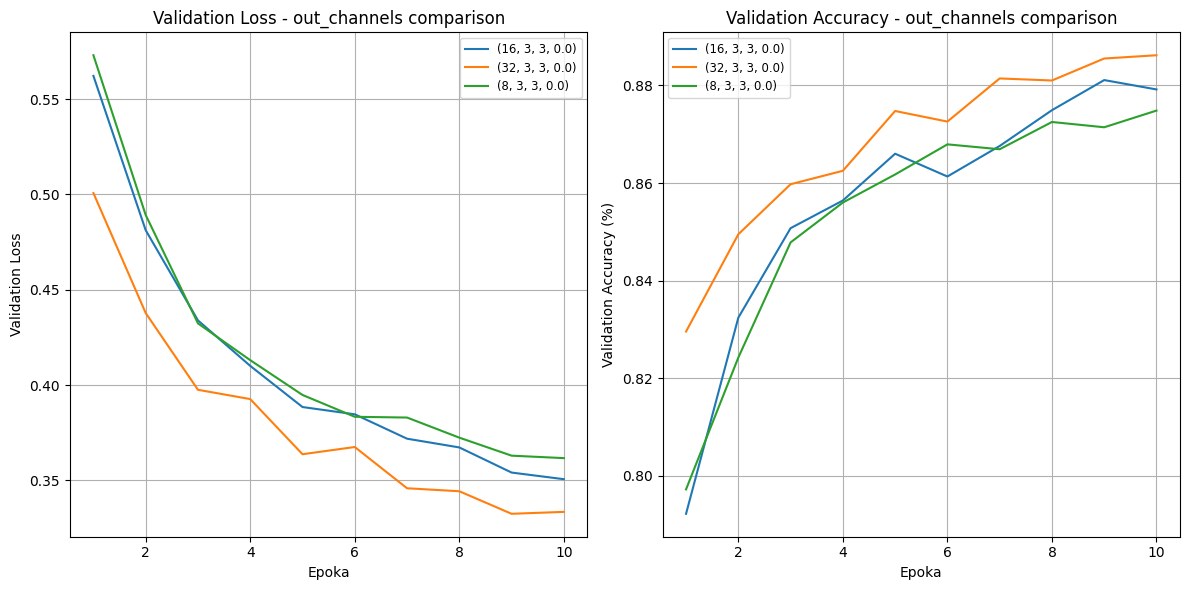

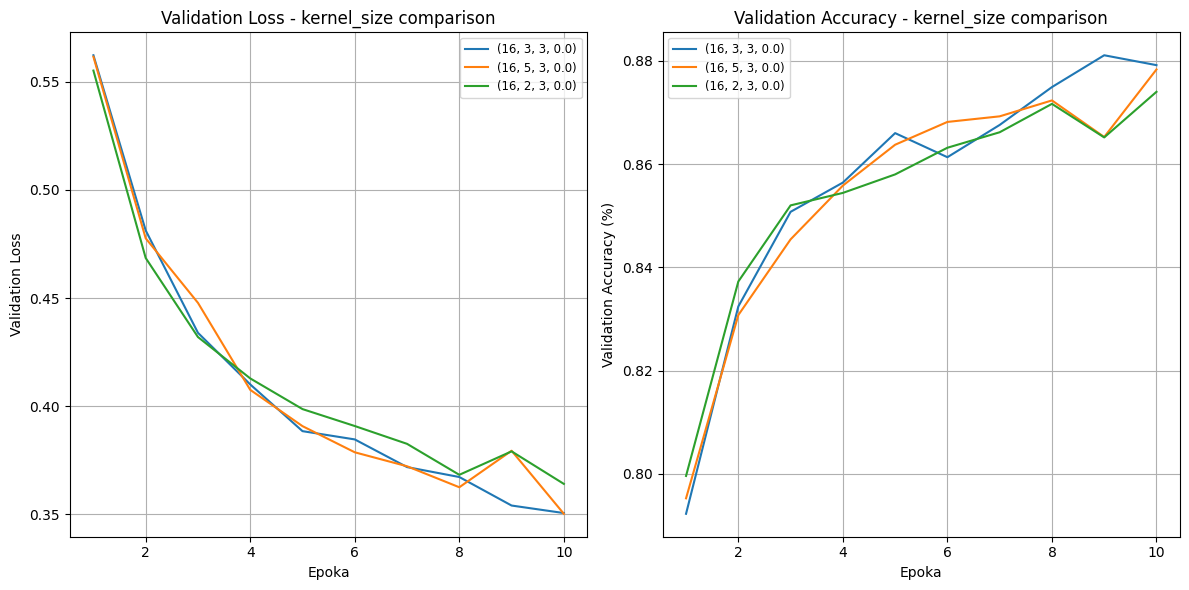

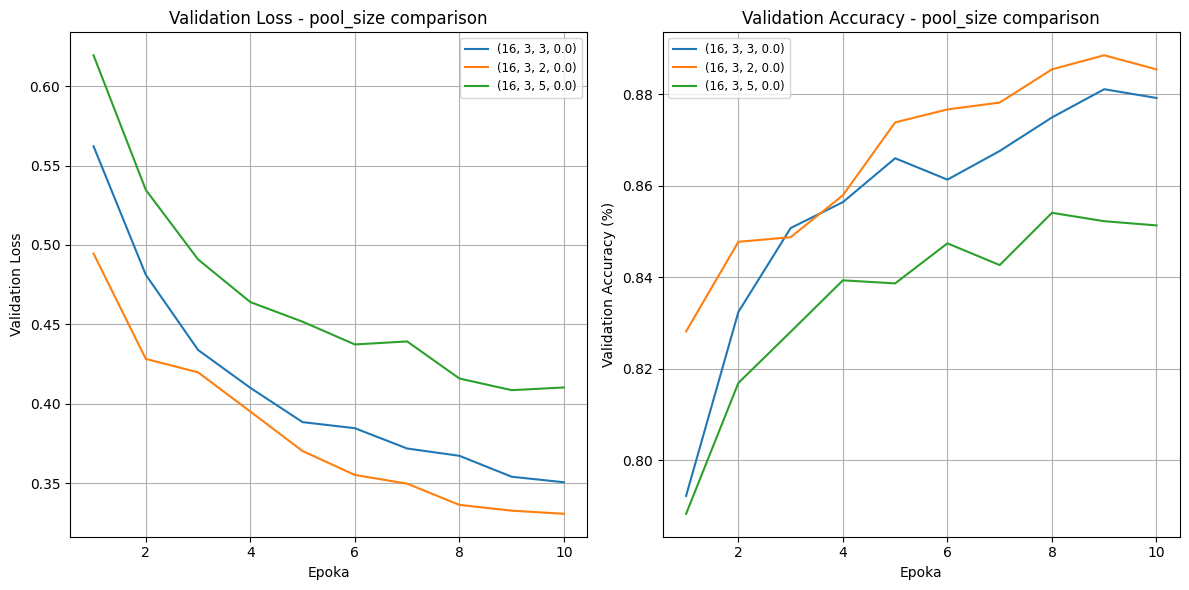

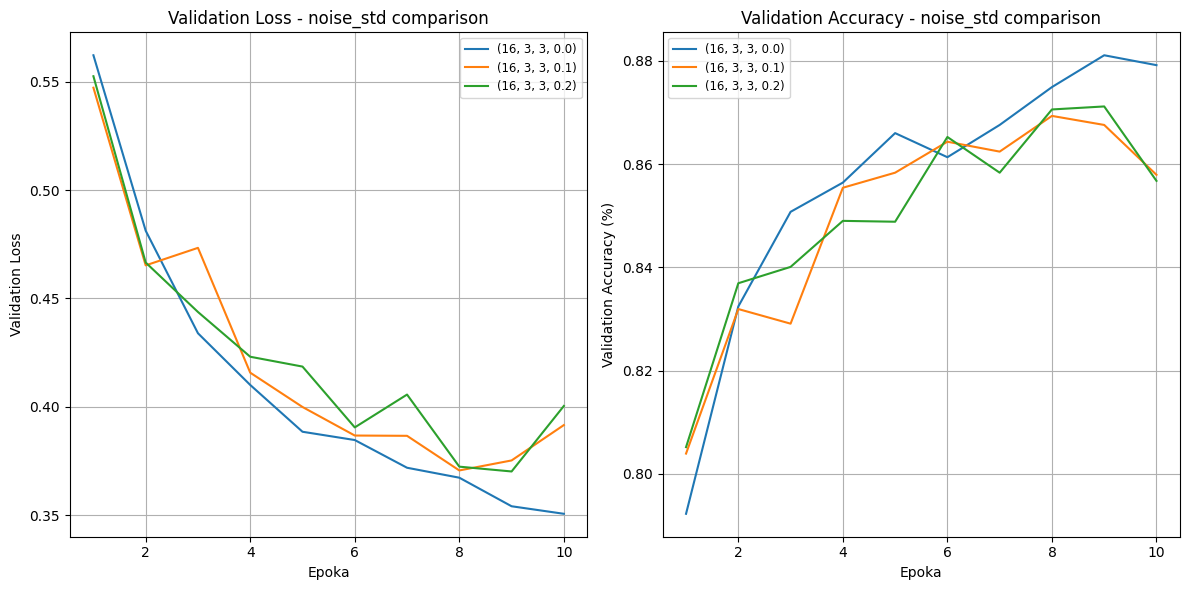

In [35]:
key_sets = [
    [(16, 3, 3, 0.0), (32, 3, 3, 0.0), (8, 3, 3, 0.0)],
    [(16, 3, 3, 0.0), (16, 5, 3, 0.0), (16, 2, 3, 0.0)],
    [(16, 3, 3, 0.0), (16, 3, 2, 0.0), (16, 3, 5, 0.0)],
    [(16, 3, 3, 0.0), (16, 3, 3, 0.1), (16, 3, 3, 0.2)],
]

epochs = range(1, 11)
colors = plt.cm.tab10.colors

for idx, key_set in enumerate(key_sets):
    plt.figure(figsize=(12, 6))
    
    if idx == 0: plot_name = "out_channels"
    elif idx == 1: plot_name = "kernel_size"
    elif idx == 2: plot_name = "pool_size"
    elif idx == 3: plot_name = "noise_std"

    # Wykres val_loss
    plt.subplot(1, 2, 1)
    for i, key in enumerate(key_set):
        if key in results:
            val_loss = [val[0] for val in results[key]]
            plt.plot(epochs, val_loss, label=str(key), color=colors[i % len(colors)])
    plt.title(f"Validation Loss - {plot_name} comparison")
    plt.xlabel("Epoka")
    plt.ylabel("Validation Loss")
    plt.legend(fontsize='small')
    plt.grid(True)
    
    # Wykres val_acc
    plt.subplot(1, 2, 2)
    for i, key in enumerate(key_set):
        if key in results:
            val_acc = [val[1] for val in results[key]]
            plt.plot(epochs, val_acc, label=str(key), color=colors[i % len(colors)])
    plt.title(f"Validation Accuracy - {plot_name} comparison")
    plt.xlabel("Epoka")
    plt.ylabel("Validation Accuracy (%)")
    plt.legend(fontsize='small')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

<h3> <b>Wnioski</b> </br>
- <b>Zestaw 1</b>: Im większa liczba kanałów wyjściowych warstwy konwolucyjnej, tym niższy loss i wyższe accuracy </br>
- <b>Zestaw 2</b>: Sieci cechują się bardzo zbliżonymi wynikami w czasie. Może być to spowodowane niewielką różnicą w rozmiarze filtra </br>
- <b>Zestaw 3</b>: Im mniejszy rozmiar okna poolingu, tym niższy loss i wyższe accuracy </br>
- <b>Zestaw 4</b>: Dodanie szumu gaussowskiego do danych zwiększa wartości straty i zmniejsza celność modelu. Różnica ta jednak zwiększa się przy 9 epoce </br>